1. Data initialization

In [1]:
import os
import pandas as pd
import numpy as np
# from featurewiz import featurewiz
from matplotlib import pyplot as plt
import json


folder = os.path.join("/", "Data", "CREMEv2_Result", "20230310", "logs_working")

if os.path.exists(folder):
    print("Path is exist!!!")
    filename_label = 'label_traffic.csv'
    filename_ready = 'label_traffic_ready_technique.csv'
    filename_train = 'label_traffic_train_technique.csv'
    label_technique = 'labels_technique.json'
    label_lifecycle = 'labels_lifecycle.json'
else:
    print("Path is not exist!!!")

Path is exist!!!


2. Data processing and feature selection

In [ ]:
fields_with_hex_value = ['Sport', 'Dport']
replace_strings = dict()
remove_rows_with_str = dict()

df = pd.read_csv(os.path.join(folder, filename_label), low_memory=False)


# one-hot encoding
# data = pd.get_dummies(data, columns=one_hot_col_list)

# # string replacement
for old_value, new_value in replace_strings.items():
    df = df.replace(to_replace=old_value, value=new_value, regex=True)
for old_value, new_value in remove_rows_with_str.items():
    df = df.replace(to_replace=old_value, value=new_value)

# preprocess hex value, str -> int
for field in fields_with_hex_value:
    df[field] = df[field].fillna(-1)
    df[field] = df[field].apply(lambda x: x if type(x) is str else int(x))
    df[field] = df[field].apply(lambda x: int(x, 0) if type(x) is str and x[:2] == "0x" else x)
    # df[field] = df[field].apply(lambda x: int(str(x), 0))
    df[field] = df[field].apply(lambda x: int(float(str(x))))


# column name cleaning
column_names = df.columns.values
for i in range(len(column_names)):
    column_names[i] = column_names[i].strip()
df.columns = column_names

# df.info()

# removing unused features from dataset
target = "Label"

feature, train = featurewiz(df, target, corr_limit=0.7, verbose=2, sep=",", header=0, test_data="", feature_engg="", category_encoders="")
df = train
print(feature)
output_filename = os.path.join(folder, filename_ready)
df.to_csv(output_filename, encoding='UTF-8', index=False)


3. Training preparation

In [ ]:

from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer

df = pd.read_csv(os.path.join(folder, filename_ready))

del_list = ['Label_lifecycle']
max_threshold = 100000
min_threshold = 20

print("origin data number: {0}".format(len(df.index)))
print("origin features: {0}".format(len(df.columns)-1))

df.drop(columns=del_list, inplace=True)

for label in df['Label'].unique():
    # if too much, try drop duplicated first
    if len(df[df['Label'] == label]) > max_threshold:
        df_tmp = df.loc[df['Label'] == label].copy()
        df_tmp.drop_duplicates(keep='last', inplace=True)
        df.drop(df[df['Label'] == label].index, inplace=True)
        df = pd.concat([df, df_tmp])
        
    # if still too much, randomly picking some of them
    if len(df[df['Label'] == label]) > max_threshold:
        df_tmp = df.loc[df['Label'] == label].copy()
        df_tmp = df_tmp.sample(n=max_threshold, random_state=47)
        df.drop(df[df['Label'] == label].index, inplace=True)
        df = pd.concat([df, df_tmp])

    # if too few, double their number until it's enough
    while len(df[df['Label'] == label]) < min_threshold:
        tmp_df = df[df['Label'] == label]
        df = pd.concat([df, tmp_df])


# feature scaling
y_tmp = df['Label']
df.drop(columns=['Label'], inplace=True)
for feature in df.columns.values:
    scaler = StandardScaler().fit(df[feature].values.reshape(-1, 1))
    df[feature] = scaler.transform(df[feature].values.reshape(-1, 1))
df = pd.concat([df, y_tmp], axis=1)


print("remain data number: {0}".format(len(df.index)))
print("remain features: {0}".format(len(df.columns)-1))

output_file = os.path.join(folder, filename_train)
df.to_csv(output_file, encoding='utf-8', index=False)




# data count per label
data_count = df['Label'].value_counts()
print(data_count)


In [ ]:
# data count per label
data_count = df['Label'].value_counts()
print(data_count)

4. Training and testing

In [3]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import pickle
import time
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import math

models_folder = "model_traffic"

df = pd.read_csv(os.path.join(folder, "toTrain", filename_train))

#labelings map
label_origin = sorted([int(i) for i in df['Label'].unique()])
le = preprocessing.LabelEncoder()
le.fit(df['Label'])
le_origin_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
origin_le_mapping = dict(zip(le.transform(le.classes_), le.classes_))

X = df.drop(columns=['Label'])
X = X.to_numpy()
y = df['Label']
y = y.to_numpy()
y = y.reshape(-1)
y = le.transform(y)


#ML training
## Define ML model
core = -1

models = {}

### Linear models
models['Logistic_Regression'] = LogisticRegression(max_iter=1500, n_jobs=core)
models['SGD'] = SGDClassifier(n_jobs=core)
models['Passive_Aggressive'] = PassiveAggressiveClassifier(n_jobs=core)
### non-linear models
models['Decision_Tree'] = DecisionTreeClassifier()
models['Extra_Tree'] = ExtraTreeClassifier()
models['Naive_Bayes'] = GaussianNB()
### models['SVM'] = SVC(kernel='rbf', gamma='auto')
models['KNN'] = KNeighborsClassifier(n_jobs=core)
### ensemble models
models['Random_Forest'] = RandomForestClassifier(n_jobs=core)
### models['Ada_Boost'] = AdaBoostClassifier()
models['Bagging'] = BaggingClassifier(n_jobs=core)
models['Extra_Trees'] = ExtraTreesClassifier(n_jobs=core)
models['Gradient_Boosting'] = GradientBoostingClassifier()
models['XGBoost'] = XGBClassifier(objective='multi:softprob', eval_metric='merror', n_jobs=core)


random_seed = 42


## training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train, y_train = SMOTE(n_jobs=-1, random_state=random_seed).fit_resample(X_train, y_train)
print("original labels:{}".format(label_origin))
print("X_train:{}, y_train:{}".format(len(X_train), len(y_train)))


evaluation = {}
for name in models:
    evaluation[name] = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
        # 'roc_auc_score': []
    }

    
for name, model in models.items():
    start_time = time.time()
    model_filename = os.path.join(models_folder, name)
    if os.path.exists(model_filename): # load the model from disk
        model = pickle.load(open(model_filename, 'rb'))
    else:
        model.fit(X_train, y_train)
        pickle.dump(model, open(model_filename, 'wb')) # save the model to disk
    y_hat = model.predict(X_test)
    end_time = time.time()
    print("model: {} \nexecution time: {:.2f}\n".format(name, end_time - start_time))
    
    # evaluation
    evaluation[name]['accuracy'].append(accuracy_score(y_test, y_hat,))
    evaluation[name]['precision'].append(precision_score(y_test, y_hat, average='weighted',zero_division=0))
    evaluation[name]['recall'].append(recall_score(y_test, y_hat, average='weighted', zero_division=0))
    evaluation[name]['f1_score'].append(f1_score(y_test, y_hat, average='weighted', zero_division=0))
    # evaluation[name]['roc_auc_score'].append(roc_auc_score(y, model.predict_proba(X)[:,1], multi_class='ovr'))

/opt/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


original labels:[0, 1, 2, 4, 6, 8, 9, 10, 11, 12, 13, 16]
X_train:960276, y_train:960276
model: Logistic_Regression 
execution time: 0.03

model: SGD 
execution time: 0.02

model: Passive_Aggressive 
execution time: 0.02

model: Decision_Tree 
execution time: 0.03

model: Extra_Tree 
execution time: 0.06

model: Naive_Bayes 
execution time: 0.42

model: KNN 
execution time: 43.72

model: Random_Forest 
execution time: 2.13

model: Bagging 
execution time: 3.69

model: Extra_Trees 
execution time: 5.70

model: Gradient_Boosting 
execution time: 5.10

model: XGBoost 
execution time: 0.21



5. Visualization Bar

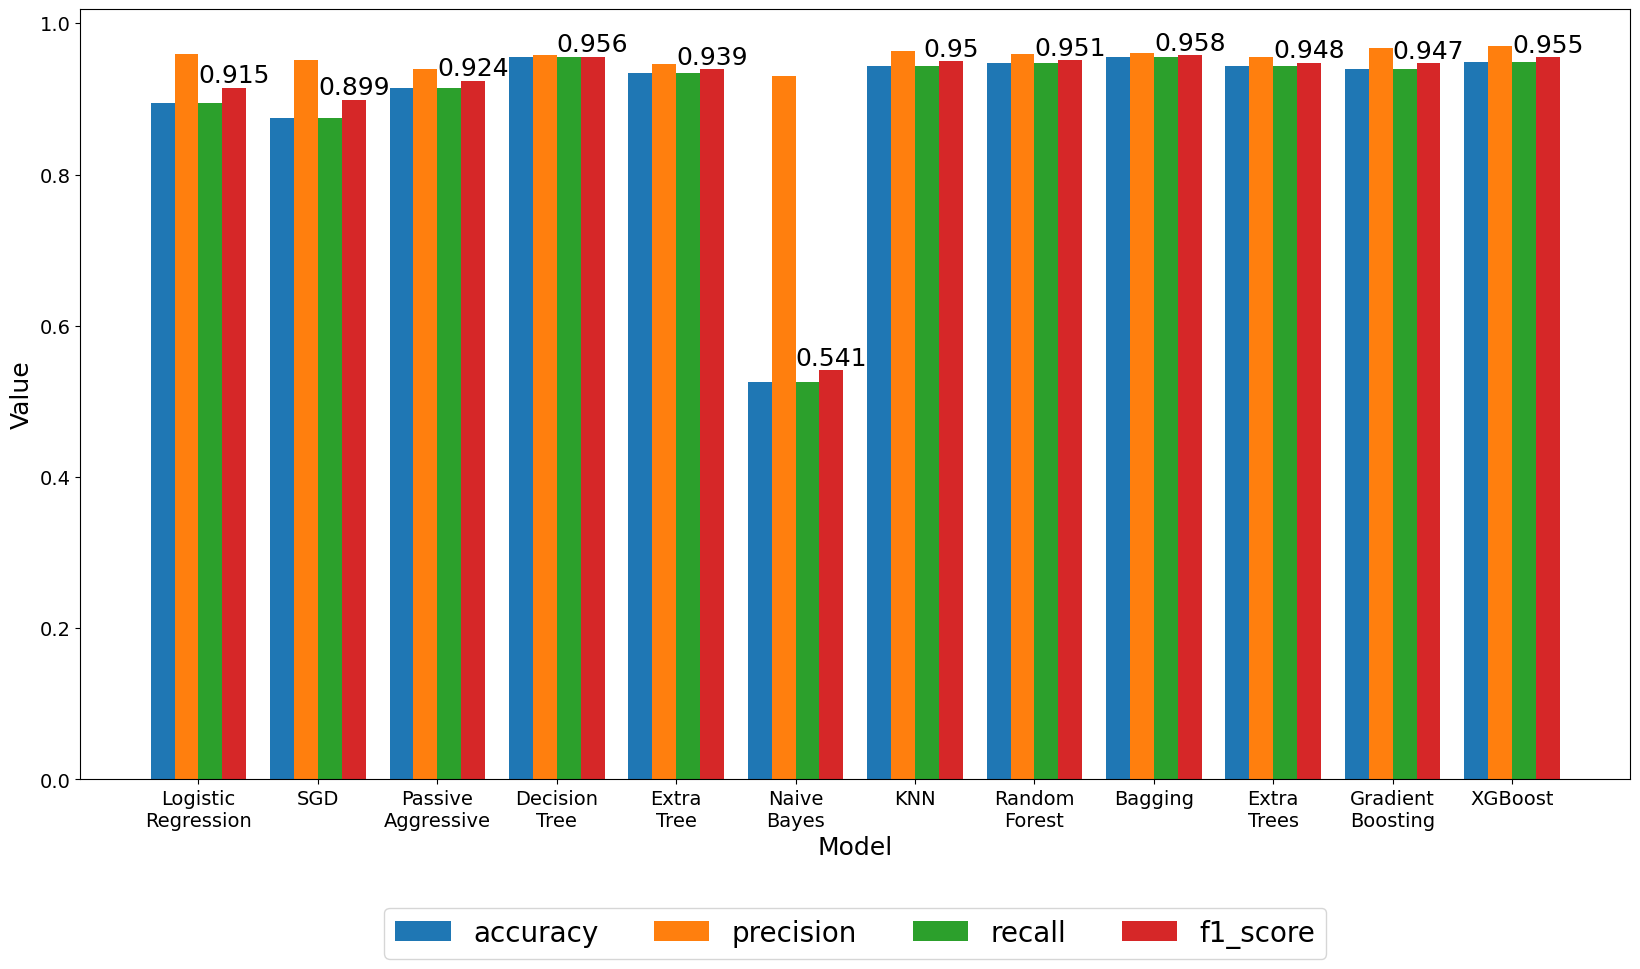

In [13]:
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import tree
import pickle

data_type = 'Nework Traffic'

def rounded(value, n):
    return math.floor(value * (10 ** n)) / float(10 ** n) 

models = [name.replace('_', '\n') for name in evaluation]
result = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}
for name in evaluation:
    for key, value in evaluation[name].items():
        result[key].append(rounded(mean(value), 3))
        
width = 0.2
x = np.arange(len(models))
plt.figure(figsize=(20, 10))
plt.bar(x, result['accuracy'], width, label='accuracy')
plt.bar(x+width, result['precision'], width, label='precision')
plt.bar(x+2*width, result['recall'], width, label='recall')
bar = plt.bar(x+3*width, result['f1_score'], width, label='f1_score')
plt.bar_label(bar, label_type='edge', fontsize=18)
# plt.title('Technique Model Evaluation for '+data_type, fontsize=30)
plt.xticks(x+1.5*width, models)
plt.xlabel('Model', fontsize=18)
plt.ylabel('Value', fontsize=18)
plt.rcParams.update({
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
})
plt.legend(loc='center', fontsize=20, ncol=4, bbox_to_anchor=(0.5,-0.2))
plt.show()


6. Confusion Matrix

In [10]:

models_folder = 'model_accounting'
name = 'XGBoost'
model_filename = os.path.join(models_folder, name)
title = "Technique Confusion Matrix of Best Model in {}".format(data_type)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
target_names = label_origin
# model = tf.keras.models.load_model(model_filename)
model = pickle.load(open(model_filename, 'rb'))
y_hat = model.predict(X_test)
# y_hat = np.argmax(y_hat, axis=1)

cm = confusion_matrix(y_test, y_hat)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.title(title, fontsize=20)
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show(block=False)

# tree.export_graphviz(model)

ValueError: Feature shape mismatch, expected: 31, got 36

In [8]:
import json

with open(os.path.join(models_folder, 'evaluation result.json'), 'w') as file:
    file.write(json.dumps(evaluation))
print(evaluation)

{'Logistic_Regression': {'accuracy': [0.8952105582241291], 'precision': [0.9596673946840782], 'recall': [0.8952105582241291], 'f1_score': [0.9157595411739059]}, 'SGD': {'accuracy': [0.8758102877395887], 'precision': [0.9529419457444804], 'recall': [0.8758102877395887], 'f1_score': [0.8998291567057366]}, 'Passive_Aggressive': {'accuracy': [0.9151937695285175], 'precision': [0.9393148511048022], 'recall': [0.9151937695285175], 'f1_score': [0.9248771103337293]}, 'Decision_Tree': {'accuracy': [0.9554166860980273], 'precision': [0.9582418840542034], 'recall': [0.9554166860980273], 'f1_score': [0.956628086832113]}, 'Extra_Tree': {'accuracy': [0.9345240871146762], 'precision': [0.9469708176086827], 'recall': [0.9345240871146762], 'f1_score': [0.9392877056555494]}, 'Naive_Bayes': {'accuracy': [0.5265587837522735], 'precision': [0.9307500331611762], 'recall': [0.5265587837522735], 'f1_score': [0.5414231246015332]}, 'KNN': {'accuracy': [0.9440609989273889], 'precision': [0.9641727464098815], 're